In [1]:
import numpy as np
import time

from pdag.data_generator import generate_random_partialB, generate_random_MVN_data
from pdag.pdag import PDAG

In [2]:
p = 20
n = 10*p
omega, B, A, G = generate_random_partialB(int(p/4), 
                                          int(2*p/4), 
                                          int(3*p/4),
                                          p = p,
                                          a = 0.3,
                                          b = 0.7,
                                          diag_a = 1,
                                          diag_b = 1,
                                          plot=False)
B = np.array(B)
X = generate_random_MVN_data(n, omega)

In [3]:
pdag = PDAG(4)
start = time.time()
Bhat = pdag.fit(X, 0.3, [int(p/4), int(2*p/4), int(3*p/4)], max_itr = 100)
#partial4.parallel_diagnostics(level=4)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 9.645796775817871


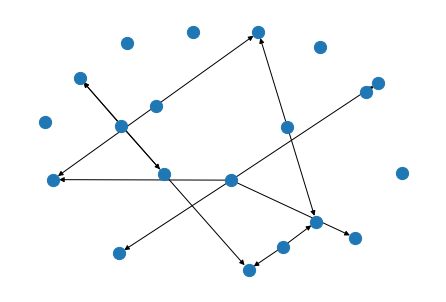

In [4]:
pdag.plotGraph()